<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/filtro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import sys
import h5py #librerua para crear archivos , h5py

In [ ]:
#hacer el mounted de mi cuenta drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks")
import unzipmodule
import graficador

In [145]:
#### creo una clase asociada al filtro pasa bajo
import matplotlib.pyplot as plt
class low_band_filter:
  def __init__(self, siganl_1,N, cutoff,sampling_frecuencie):
    self.signal_1=signal_1
    self.order=N
    self.cutoff=cutoff
    self.sampling_frecuencie=sampling_frecuencie
    self.sos = None  # Initialize sos as None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    b, a = signal.butter(self.order,self.cutoff/fnqy, 'low', True) #coeficientes de la funcion de transferencia
    w, h = signal.freqs(b, a)
    self.sos = signal.butter(self.order, self.cutoff/fnqy, analog=False, btype='low', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)


#### creo una clase asociada al filtro pasa banda
class pass_band_filter:
  def __init__(self, siganl_1,wp,ws,sampling_frecuencie):
    self.signal_1=signal_1
    self.wp=wp
    self.ws=ws
    self.sampling_frecuencie=sampling_frecuencie
    self.sof=None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    N, Wn = signal.buttord([self.wp[0]/fnqy,self.wp[1]/fnqy], [self.ws[0]/fnqy, self.ws[1]/fnqy], 3, 40, True)
    b, a = signal.butter(N, Wn, 'band', True)
    w, h = signal.freqs(b, a)
    self.sos = signal.butter(N, Wn, 'band', fs=25.6e3, output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)

In [8]:
## grafico el bode del filtro (amplitud y fase)
def graph_maker(w, h, filter_type,sampling_frecuencie):
    fnqy=sampling_frecuencie/2
    if filter_type == 'low':
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(w * fnqy, 20 * np.log10(abs(h)))
        plt.title('Butterworth lowpass filter')
        plt.xlabel('Frequency [Hz ]')
        plt.ylabel('Amplitude [dB]')
        plt.grid(True)
        plt.axis([1, np.max(w) * fnqy, -60, 3])

        # Plot the phase response
        plt.subplot(2, 1, 2)
        angles = np.unwrap(np.angle(h))
        plt.plot(w * fnqy, angles)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (radians)')
        plt.grid(True)
        plt.axis([1, np.max(w) * fnqy, -60, 3])

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(w * fnqy, 20 * np.log10(abs(h)))
        plt.title('Butterworth bandpass filter')
        plt.xlabel('Frequency [Hz ]')
        plt.ylabel('Amplitude [dB]')
        plt.grid(True)
        plt.axis([1, 200, -60, 3])

        # Plot the phase response
        plt.subplot(2, 1, 2)
        angles = np.unwrap(np.angle(h))
        plt.plot(w * fnqy, angles)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Phase (radians)')
        plt.grid(True)
        plt.axis([1, 200, -60, 3])

        plt.tight_layout()
        plt.show()


In [142]:
# grafico la señal sin filtraer y filtrada
def graph_function(t, signal_1, filtered, type_filter):
    if type_filter == "low":
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.plot(t, signal_1)
        ax1.set_title('Señal sin filtro')
        ax1.axis([0, 1, -2, 2])

        ax2.plot(t, filtered)
        ax2.set_title('After 63Hz low-pass filter using sos')
        ax2.set_xlabel('Time [seconds]')
        ax2.axis([0, 1, -2, 2])

        plt.tight_layout()
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        ax1.plot(t, signal_1)
        ax1.set_title('Señal sin filtro')
        ax1.axis([0, 1, -2, 2])

        ax2.plot(t, filtered)
        ax2.set_title('After bandpass filter using sos')
        ax2.set_xlabel('Time [seconds]')
        ax2.axis([0, 1, -2, 2])

        plt.tight_layout()

In [ ]:
#celda para crear la lista con los paths de mi data
paths=[] #creo la lista de pahts
names=[] #creo la lista de nombres
output_file=[]
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/vibration_1')
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part1')
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part2')
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part3')
names.append('vibration')
names.append('part1')
names.append('part2')
names.append('part3')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/vibration_1/vibration')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part1/part1')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part2/part2')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part3/part3')


In [ ]:
h5py_file =output_file[1]
with h5py.File(h5py_file, 'r') as h5_file:
  keys = list(h5_file.keys())
  selected_key = keys[0]
  selected_data = h5_file[selected_key][:]

selected_key

'vibration_ball_0'

In [84]:
60*(1/2)**2

15.0

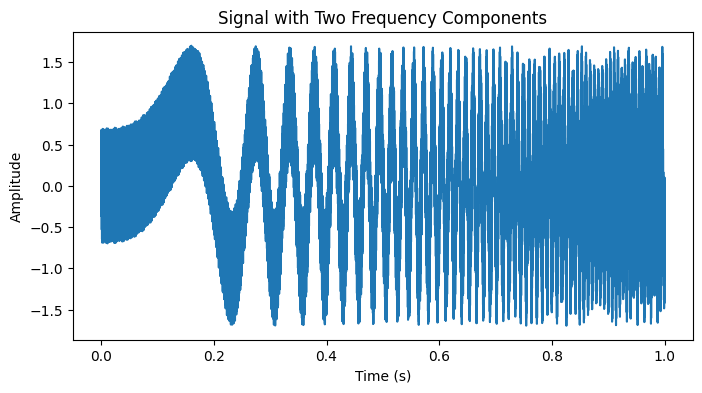

In [6]:
duration = 1  # Duration of the signal (seconds)
fs = 25.6e3 # Sampling rate (Hz
t = np.linspace(0, duration, int(fs * duration))
f1=60*t**2
f2=60*7
f3=3e3
signal_1 = np.sin(2 * np.pi * f1 * t) +0.2* np.sin(2 * np.pi * f2 * t)+0.5* np.sin(2 * np.pi * f3 * t)
plt.figure(figsize=(8, 4))
plt.plot(t, signal_1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Signal with Two Frequency Components')
plt.show()

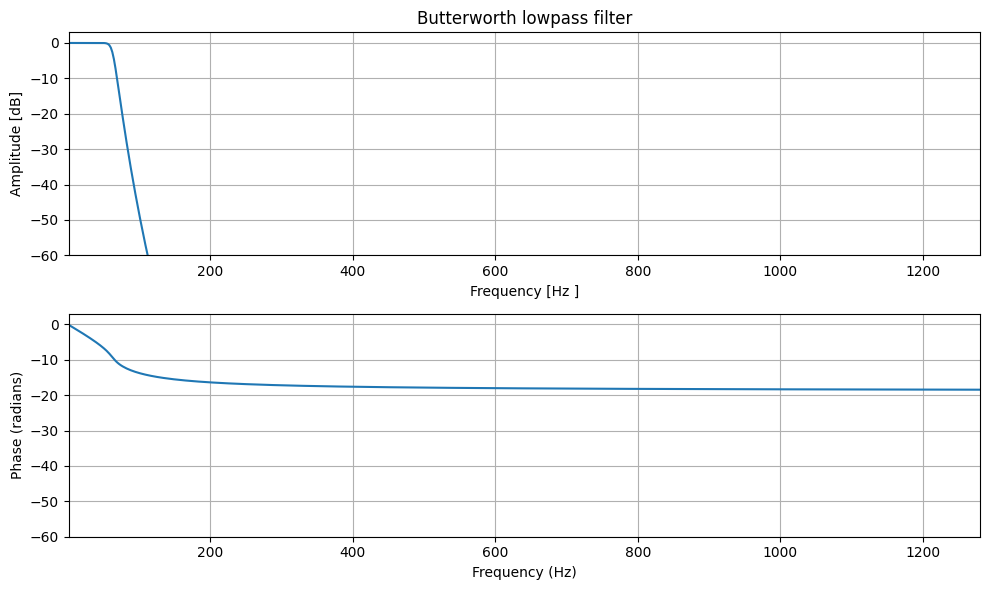

In [148]:
#pruebo el filtro pasa bajo
first_filter=low_band_filter(signal_1,12,63,25.6e3)
w,h=first_filter.filter_making()
graph_maker(w, h, "low",25.6e3)


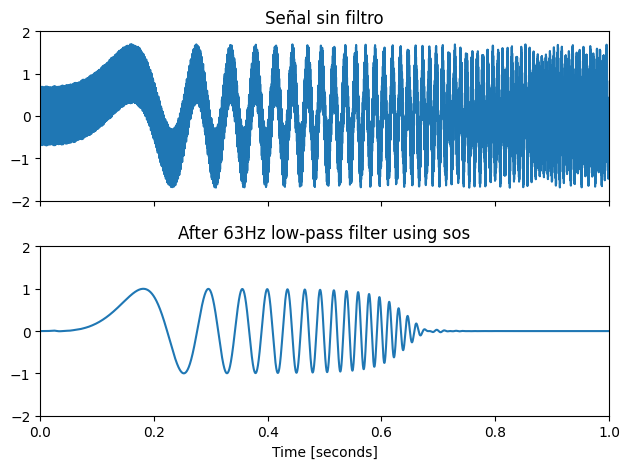

In [147]:
filtered=first_filter.filtered_signal()
graph_function(t, signal_1, filtered, "low")

In [ ]:
wp=[15,60]
ws=[10,70]
second_filter=pass_band_filter(signal_1,wp,ws,25.6e3)
w,h=second_filter.filter_making()
graph_maker(w, h, "bandpass",25.6e3)

In [ ]:
filtered=second_filter.filtered_signal()
graph_function(t, signal_1, filtered, "band")

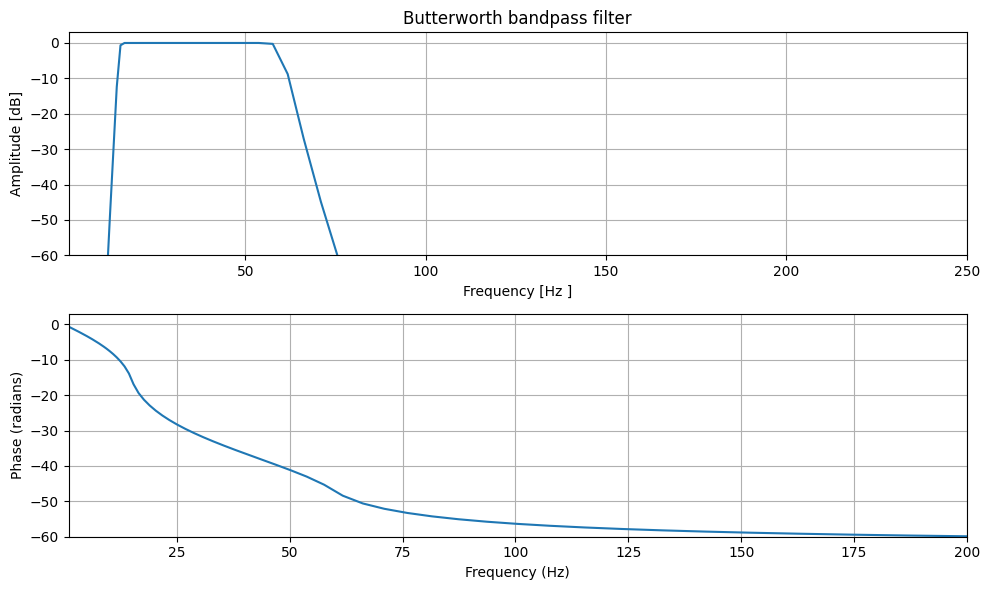

In [86]:
wp=[15,60]
ws=[10,70]
fs = 25.6e3  # Tasa de muestreo (Hz)
fnqy = fs / 2

N, Wn = signal.buttord([wp[0] / fnqy, wp[1] / fnqy], [ws[0] / fnqy, ws[1] / fnqy], 3, 40, True)
b, a = signal.butter(N, Wn, 'band', True)
w, h = signal.freqs(b, a)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(w * fnqy, 20 * np.log10(abs(h)))
plt.title('Butterworth bandpass filter')
plt.xlabel('Frequency [Hz ]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.axis([1,250, -60, 3])

# Plot the phase response
plt.subplot(2, 1, 2)
angles = np.unwrap(np.angle(h))
plt.plot(w * fnqy, angles)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.grid(True)
plt.axis([1, 200, -60, 3])

plt.tight_layout()
plt.show()




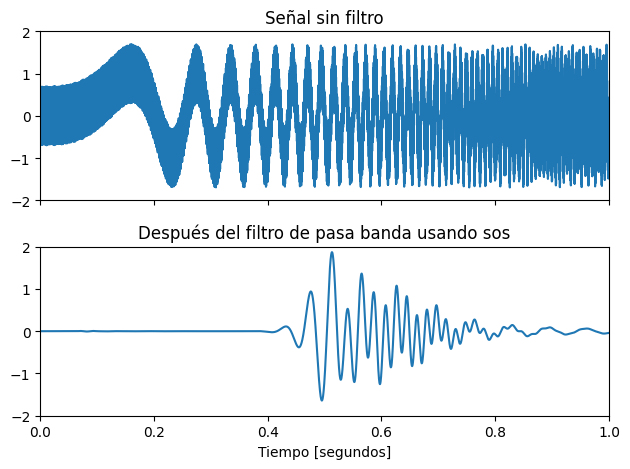

In [133]:

wp=[15,60]
ws=[10,70]
fs = 25.6e3  # Tasa de muestreo (Hz)
fnqy = fs / 2

N, Wn = signal.buttord([wp[0]/fnqy , wp[1]/fnqy ], [ws[0]/fnqy , ws[1]/fnqy ], 3, 40, True)
sos = signal.butter(N, Wn,  analog=False, btype='band', output='sos')
filtered=signal.sosfilt(sos, signal_1)




fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, signal_1)
ax1.set_title('Señal sin filtro')
ax1.axis([0, 1, -2, 2])

ax2.plot(t, filtered)
# ax2.plot(t, sf )
ax2.set_title('Después del filtro de pasa banda usando sos')
ax2.set_xlabel('Tiempo [segundos]')
ax2.axis([0, 1, -2, 2])

plt.tight_layout()

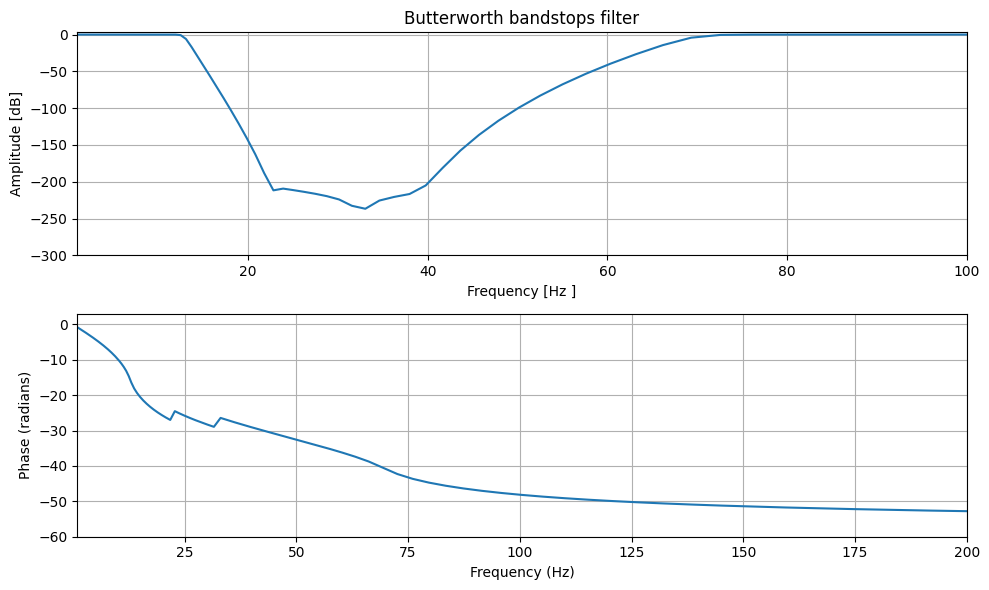

In [129]:
ws=[15,60]
wp=[10,70]
fs = 25.6e3  # Tasa de muestreo (Hz)
fnqy = fs / 2

N, Wn = signal.buttord([wp[0] / fnqy, wp[1] / fnqy], [ws[0] / fnqy, ws[1] / fnqy], 3, 40, True)
b, a = signal.butter(N, Wn, 'bandstop', True)
w, h = signal.freqs(b, a)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(w * fnqy, 20 * np.log10(abs(h)))
plt.title('Butterworth bandstops filter')
plt.xlabel('Frequency [Hz ]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.axis([1,100, -300, 3])

# Plot the phase response
plt.subplot(2, 1, 2)
angles = np.unwrap(np.angle(h))
plt.plot(w * fnqy, angles)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (radians)')
plt.grid(True)
plt.axis([1, 200, -60, 3])

plt.tight_layout()
plt.show()

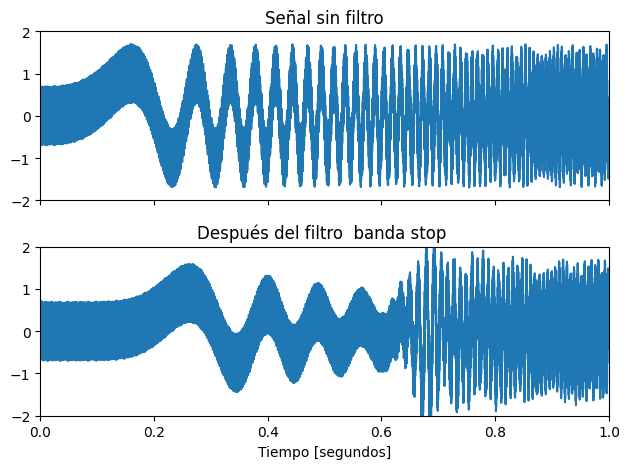

In [140]:

N, Wn = signal.buttord([wp[0]/fnqy , wp[1]/fnqy ], [ws[0]/fnqy , ws[1]/fnqy ], 3, 40, True)
sos = signal.butter(N, Wn,  analog=False, btype='stop', output='sos')
filtered=signal.sosfilt(sos, signal_1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, signal_1)
ax1.set_title('Señal sin filtro')
ax1.axis([0, 1, -2, 2])

ax2.plot(t, filtered)
# ax2.plot(t, sf )
ax2.set_title('Después del filtro  banda stop ')
ax2.set_xlabel('Tiempo [segundos]')
ax2.axis([0, 1, -2, 2])

plt.tight_layout()

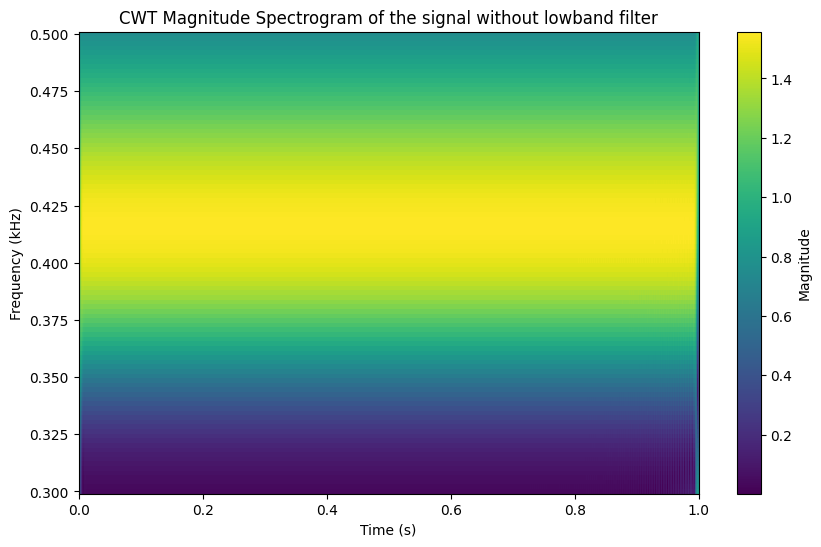

In [ ]:

from scipy import signal
w =7
freq = np.linspace(300,500, 100)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(signal_1, signal.morlet2, widths, w=w)


plt.figure(figsize=(10, 6))
plt.pcolormesh(t, freq/1e3, np.abs(cwtm), cmap='viridis', shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('CWT Magnitude Spectrogram of the signal without lowband filter')
plt.show()

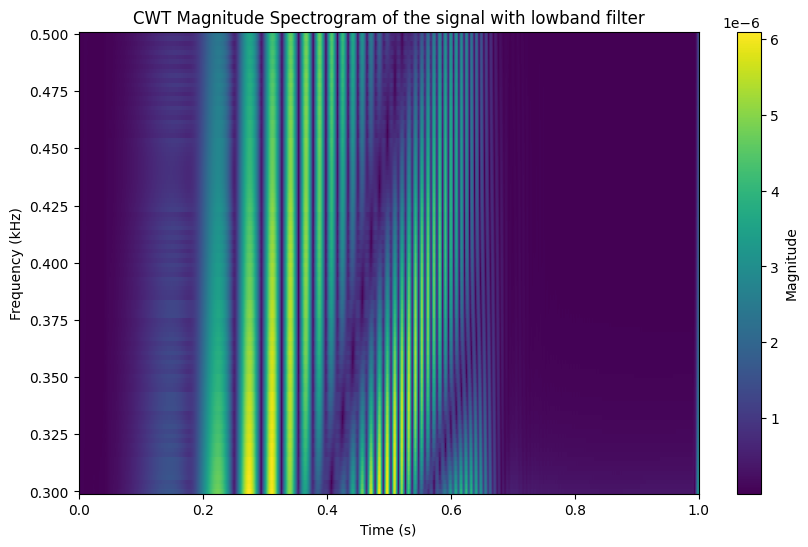

In [ ]:
from scipy import signal
w =7
freq = np.linspace(300,500, 100)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(filtered , signal.morlet2, widths, w=w)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, freq/1e3, np.abs(cwtm), cmap='viridis', shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('CWT Magnitude Spectrogram of the signal with lowband filter')
plt.show()

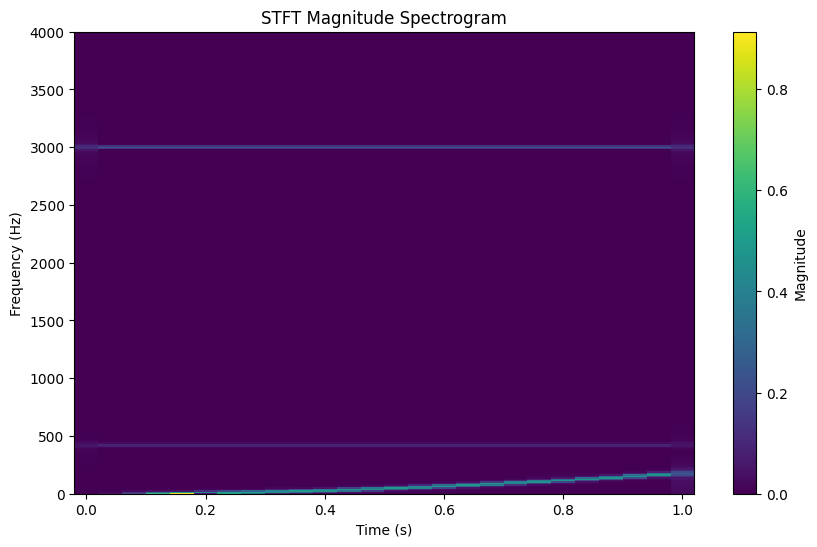

In [ ]:
from scipy.signal import stft
frequencies, time_points, magnitude = stft(signal_1, fs, window='hann', nperseg=2048, noverlap= 1024)

# Plot the magnitude spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(time_points, frequencies, np.abs(magnitude), shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT Magnitude Spectrogram')
fs_limit=4e3
plt.ylim(0, fs_limit)  # Set the frequency range for visualization
plt.show()

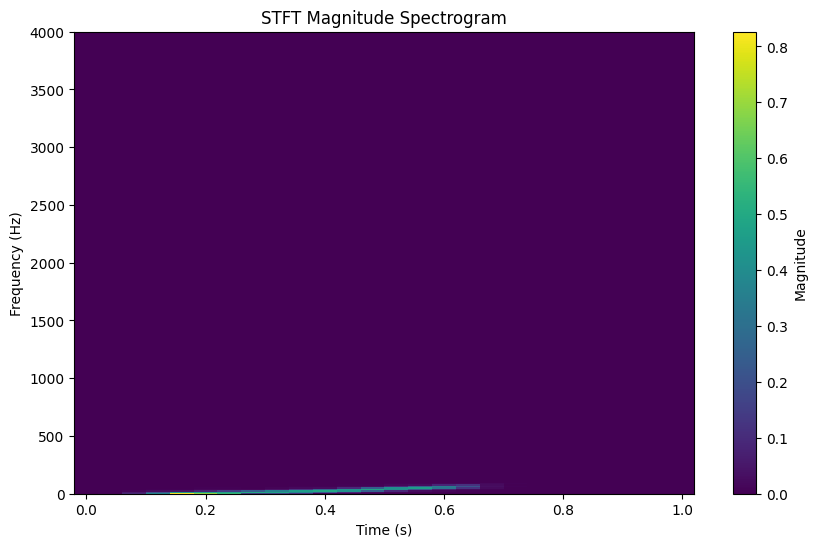

In [ ]:
from scipy.signal import stft
frequencies, time_points, magnitude = stft(filtered, fs, window='hann', nperseg=2048, noverlap= 1024)

# Plot the magnitude spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(time_points, frequencies, np.abs(magnitude), shading='auto')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('STFT Magnitude Spectrogram')
fs_limit=4e3
plt.ylim(0, fs_limit)  # Set the frequency range for visualization
plt.show()